In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, regularizers, Input
from tensorflow.keras.models import Sequential

# 新增區段

In [ ]:
import pathlib

data_url = 'https://drive.google.com/drive/u/0/my-drive?hl=zh-TW/'
data_dir = tf.keras.utils.get_file('train', origin=data_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')
print(data_dir)

 532480/Unknown 0s 0us/step/root/.keras/datasets/train


/tmp/ipython-input-1064052417.py:4: UserWarning: Could not extract archive.
  data_dir = tf.keras.utils.get_file('train', origin=data_url, extract=True)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    '/content/gdrive/MyDrive/train')

batch_size = 32
img_height = 240
img_width = 240
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/gdrive/MyDrive/train',
    image_size=(img_height, img_width),
    batch_size=batch_size)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/gdrive/MyDrive/validate',
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 825 files belonging to 3 classes.
Found 825 files belonging to 3 classes.
Found 90 files belonging to 3 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['adidas', 'converse', 'nike']


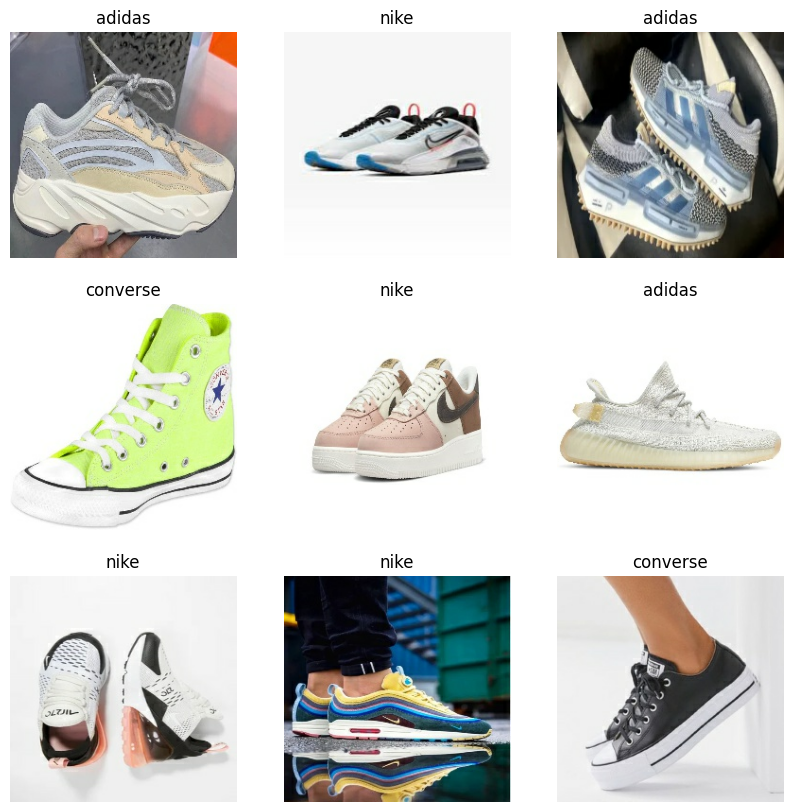

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 240, 240, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
num_classes = len(class_names)



data_augmentation = Sequential([
    layers.RandomRotation(0.0417),         # ~15 degrees
    layers.RandomZoom(0.1),                # Zoom range [0.9, 1.1]
    layers.RandomBrightness(factor=0.2),   # Brightness range [0.8, 1.2]
    layers.RandomFlip("horizontal")        # Horizontal flip
])

model = Sequential([
    # Data Augmentation + Rescaling
    Input(shape=(img_height, img_width, 3)),
    data_augmentation,
    layers.Rescaling(1./255),

    # First Convolutional Block
    layers.Conv2D(16, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.005)),
    layers.MaxPooling2D((2, 2)),


    # Second Convolutional Block
    layers.Conv2D(32, (4, 4), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.005)),
    layers.MaxPooling2D((4, 4)),


    # Third Convolutional Block
    layers.Conv2D(64, (5, 5), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.005)),
    layers.MaxPooling2D((5, 5)),
    layers.Dropout(0.3),


    # Flatten and Dense Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.005)),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 240, 240, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 120, 120, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 120, 120, 32)   │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,363 (1.36 MB)

 Trainable params: 355,363 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 789ms/step - accuracy: 0.3109 - loss: 2.4487 - val_accuracy: 0.3111 - val_loss: 1.8519
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.3985 - loss: 1.7418 - val_accuracy: 0.3889 - val_loss: 1.4809
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3833 - loss: 1.4496 - val_accuracy: 0.5333 - val_loss: 1.3252
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.4185 - loss: 1.3291 - val_accuracy: 0.5889 - val_loss: 1.2063
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4857 - loss: 1.2387 - val_accuracy: 0.5111 - val_loss: 1.1725
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4809 - loss: 1.1888 - val_accuracy: 0.5889 - val_loss: 1.1176
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4522 - loss: 1.1575 - val_accuracy: 0.5556 - val_loss: 1.0682
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5006 - loss: 1.1323 - val_accuracy: 0.5778 -

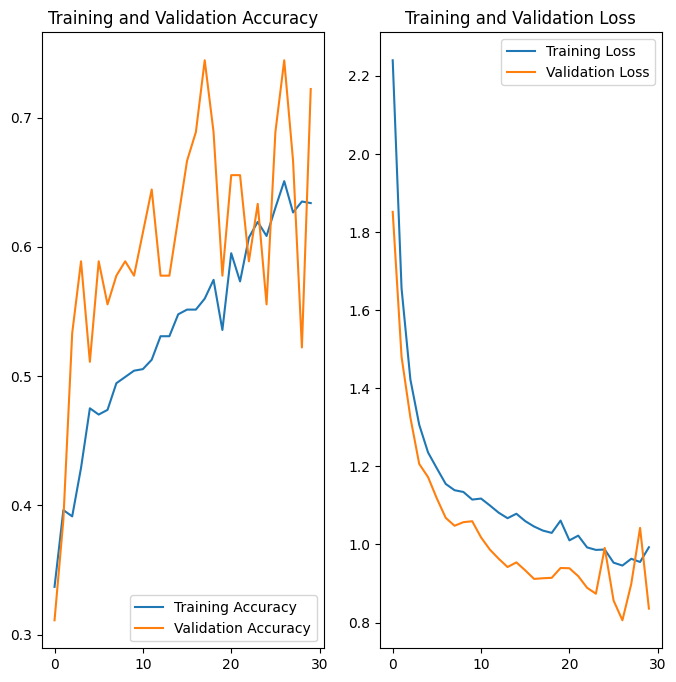

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# data_augmentation = keras.Sequential(
#   [
#     layers.RandomFlip("horizontal",
#                       input_shape=(img_height,
#                                   img_width,
#                                   3)),
#     layers.RandomRotation(0.1),
#     layers.RandomZoom(0.1),
#   ]
# )

In [ ]:
# plt.figure(figsize=(10, 10))
# for images, _ in train_ds.take(1):
#   for i in range(9):
#     augmented_images = data_augmentation(images)
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(augmented_images[0].numpy().astype("uint8"))
#     plt.axis("off")

In [ ]:
# model = Sequential([
#   data_augmentation,
#   layers.Rescaling(1./255),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(128, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Dropout(0.2),
#   layers.Flatten(),
#   layers.Dense(256, activation='relu'),
#   layers.Dense(num_classes, name="outputs")
# ])

In [ ]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [ ]:
# model.summary()

In [ ]:
model.save('Mymodel2.keras')

In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model('Mymodel2.keras')

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import pathlib

# Load model
model = load_model('Mymodel2.keras')

# Set dataset path and parameters
data_dir = pathlib.Path('/content/gdrive/MyDrive/new_test_sub')
image_size = (240, 240)
batch_size = 32

# Create validation dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

# Normalize pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Optimize performance with caching and prefetching
AUTOTUNE = tf.data.AUTOTUNE
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Evaluate model
loss, accuracy = model.evaluate(test_ds)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")

# Optional: Print dataset size and class names
print(f"Test samples: {tf.data.experimental.cardinality(test_ds).numpy() * batch_size}")
#print(f"Class names: {test_ds.class_names}")


Found 60 files belonging to 3 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 5s/step - accuracy: 0.4306 - loss: 1.2060

Test Accuracy: 33.33%
Test Loss: 1.2486
Test samples: 64
